# Usage notebook

This notebook will analyse the general usage of the assistant in the participating courses

In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getpass import getpass
import pandas as pd

## Load the data from the database

In [2]:
# Configure the database
DB_TYPE = 'postgresql'
DB_DRIVER = 'psycopg2'
DB_USER = 'postgres'
DB_PASS = getpass('Enter your database password: ')
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'kthassistant_local'

DATABASE_URL = f'{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(DATABASE_URL)

In [3]:
# Load all data, re-run this to refresh
tables = [
    'chat_configs',
    'chats',
    'content',
    'cookies',
    'courses',
    'faq_snapshots',
    'faqs',
    'feedback',
    'feedback_questions',
    'messages',
    'migratehistory',
    'prompt_handles',
    'sessions',
    'snapshots',
    'urls'
]

dataframes = {}
for table in tqdm(tables):
    dataframes[table] = pd.read_sql_table(table, engine)

  0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
# Print the structure
for table, df in dataframes.items():
    print(f"Structure of DataFrame for table `{table}`")
    print(df.info())
    print("\n")

Structure of DataFrame for table `chat_configs`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15 non-null     int64         
 1   created_at      15 non-null     datetime64[ns]
 2   modified_at     15 non-null     datetime64[ns]
 3   is_active       15 non-null     bool          
 4   llm_model_name  15 non-null     object        
 5   index_type      15 non-null     object        
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 747.0+ bytes
None


Structure of DataFrame for table `chats`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                5223 non-null   int64         
 1   created_at        5223 non-nu

## Number of chats per day (cummulative)

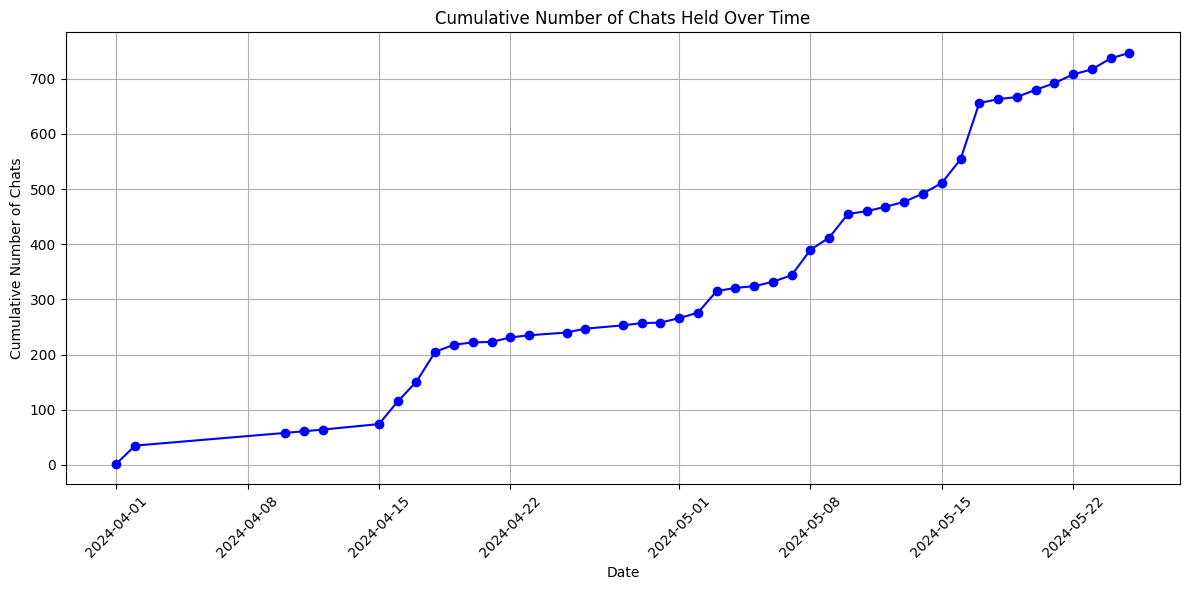

In [5]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

chats_per_day_filtered = df_filtered.groupby(df_filtered['created_at'].dt.date).size()
chats_per_day_cumulative = chats_per_day_filtered.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(chats_per_day_cumulative.index, chats_per_day_cumulative.values, marker='o', linestyle='-', color='b')
plt.title('Cumulative Number of Chats Held Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Chats')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

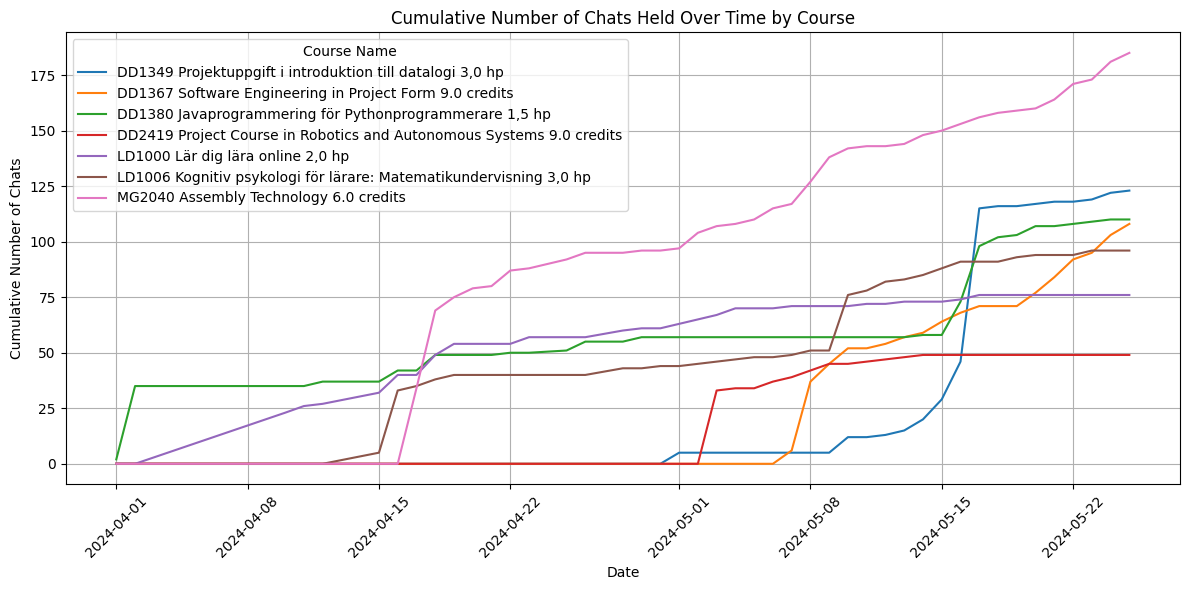

In [6]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left', suffixes=('', '_session'))

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered_with_names = df_filtered_with_names[~df_filtered_with_names['course_id'].isin([1, 6])]

chats_per_day_per_course_name = df_filtered_with_names.groupby(['name', df_filtered_with_names['created_at'].dt.date]).size().unstack(fill_value=0)

cumulative_chats_per_course_name = chats_per_day_per_course_name.cumsum(axis=1).T

plt.figure(figsize=(12, 6))
for course_name in cumulative_chats_per_course_name.columns:
    plt.plot(cumulative_chats_per_course_name.index, cumulative_chats_per_course_name[course_name], linestyle='-', label=course_name)

plt.title('Cumulative Number of Chats Held Over Time by Course')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Chats')
plt.legend(title='Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Chats per week

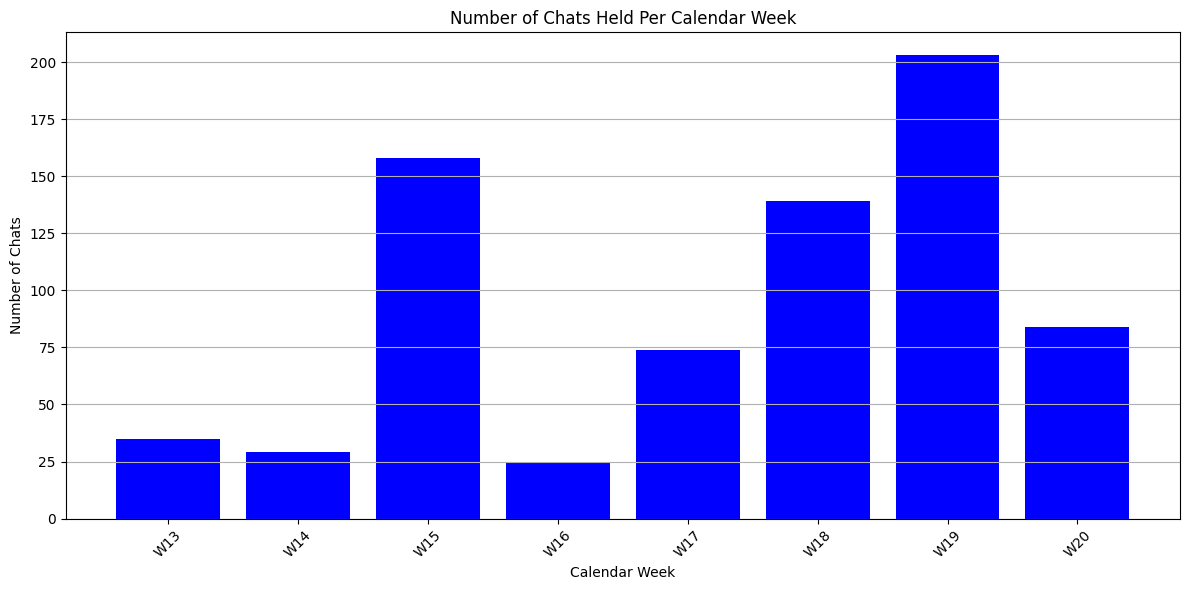

In [7]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

df_filtered['week'] = df_filtered['created_at'].dt.strftime('W%U')

chats_per_week_calendar = df_filtered.groupby('week').size()

plt.figure(figsize=(12, 6))
plt.bar(chats_per_week_calendar.index, chats_per_week_calendar.values, color='b')
plt.title('Number of Chats Held Per Calendar Week')
plt.xlabel('Calendar Week')
plt.ylabel('Number of Chats')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

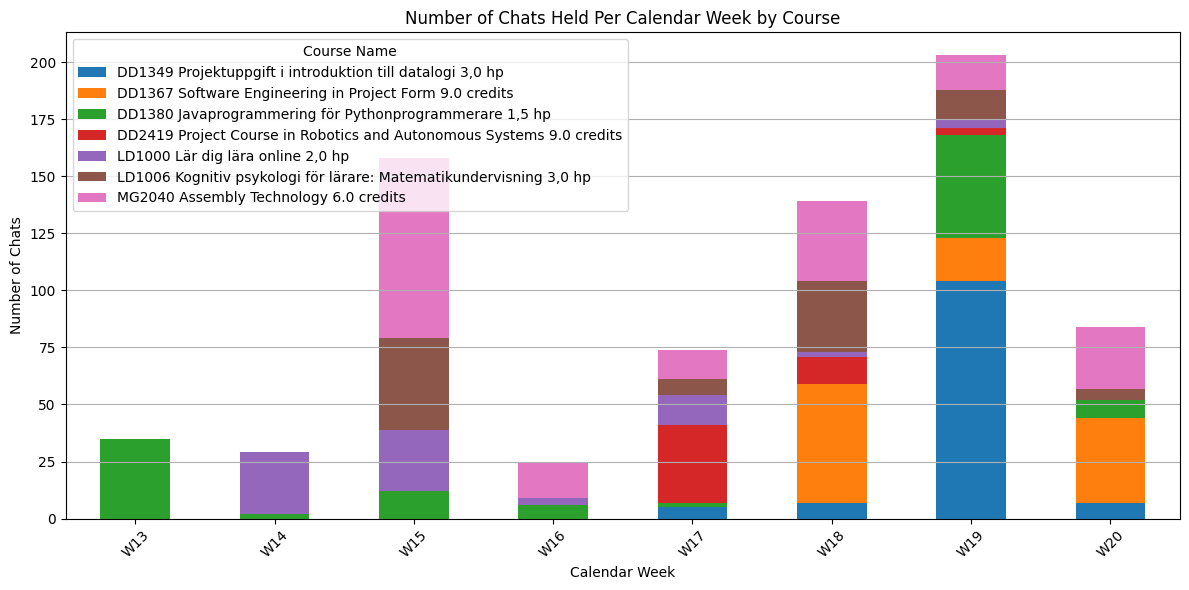

In [8]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

df_filtered_with_names['week'] = df_filtered_with_names['created_at'].dt.strftime('W%U')
chats_per_week_per_course = df_filtered_with_names.groupby(['name', 'week']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
chats_per_week_per_course.T.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Number of Chats Held Per Calendar Week by Course')
plt.xlabel('Calendar Week')
plt.ylabel('Number of Chats')
plt.legend(title='Course Name')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

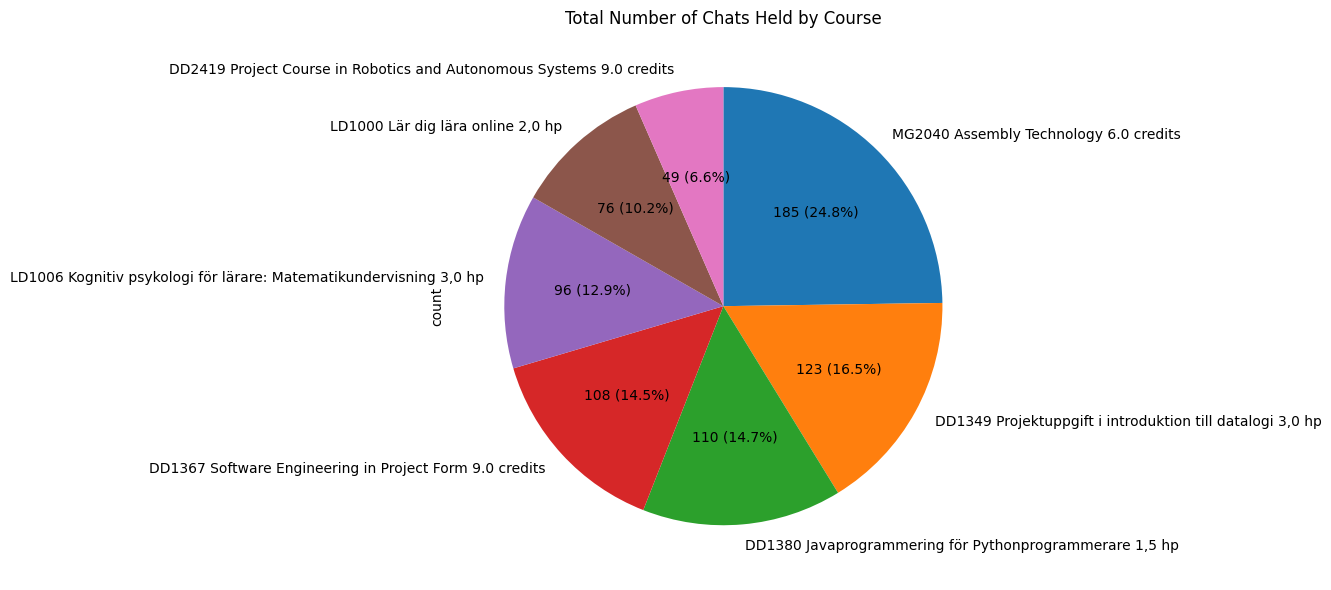

In [9]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

total_chats_per_course = df_filtered_with_names['name'].value_counts()

plt.figure(figsize=(12, 6))
total_chats_per_course.plot(kind='pie', autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_chats_per_course.sum() / 100, p), startangle=90, counterclock=False)

plt.title('Total Number of Chats Held by Course')
plt.tight_layout()
plt.show()

## Number of sessions (number of users)

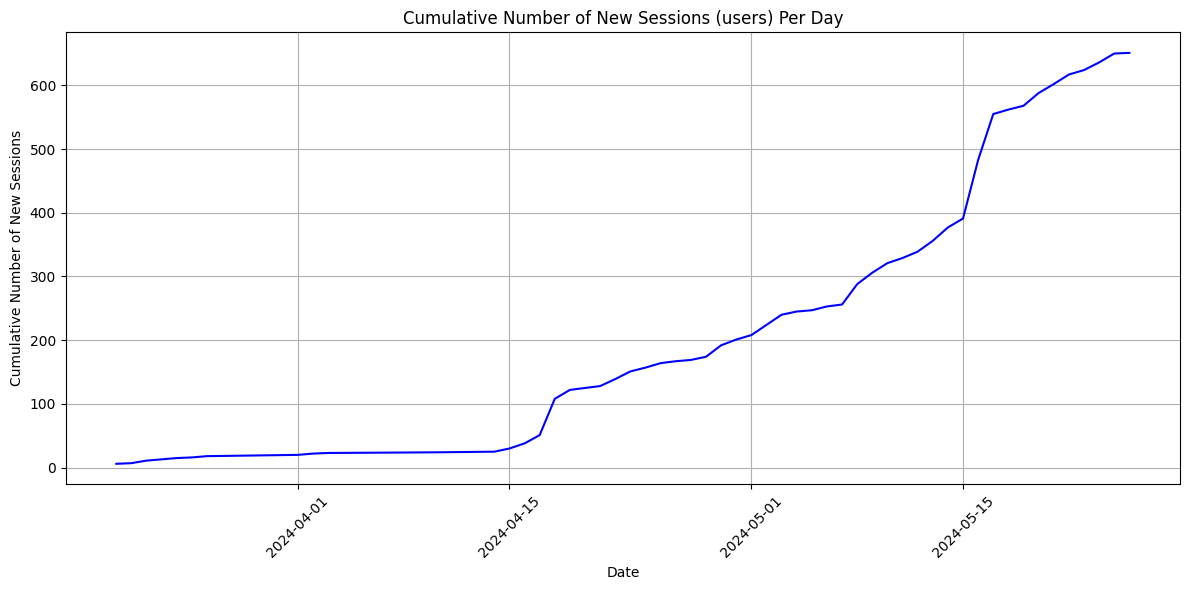

In [10]:
df_sessions = dataframes['sessions']

df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])

df_sessions_filtered = df_sessions[df_sessions['is_test_user'] == False].copy()

sessions_per_day = df_sessions_filtered.groupby(df_sessions_filtered['created_at'].dt.date).size()

cumulative_sessions_per_day = sessions_per_day.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_sessions_per_day.index, cumulative_sessions_per_day.values, marker='', linestyle='-', color='b')
plt.title('Cumulative Number of New Sessions (users) Per Day')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of New Sessions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

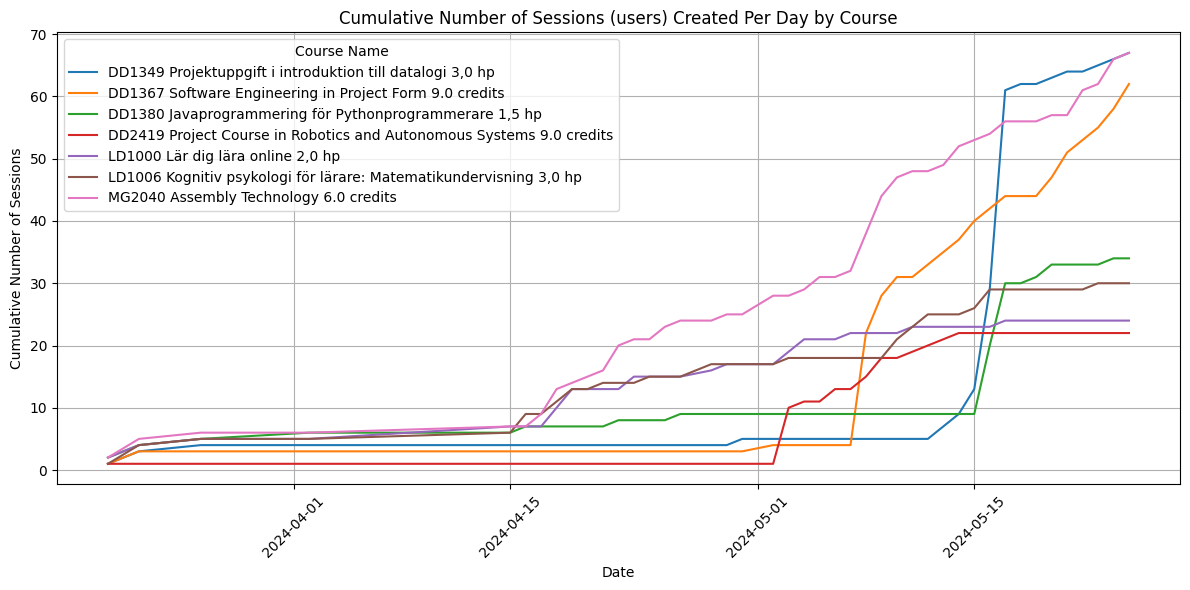

In [11]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])
df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user', 'created_at']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

sessions_per_day_per_course = df_filtered_with_names.groupby(['name', df_filtered_with_names['created_at_y'].dt.date])['session_id'].nunique().unstack(fill_value=0)

cumulative_sessions_per_course = sessions_per_day_per_course.cumsum(axis=1).T

plt.figure(figsize=(12, 6))
for course_name in cumulative_sessions_per_course.columns:
    plt.plot(cumulative_sessions_per_course.index, cumulative_sessions_per_course[course_name], marker='', linestyle='-', label=course_name)

plt.title('Cumulative Number of Sessions (users) Created Per Day by Course')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Sessions')
plt.legend(title='Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Number of messages

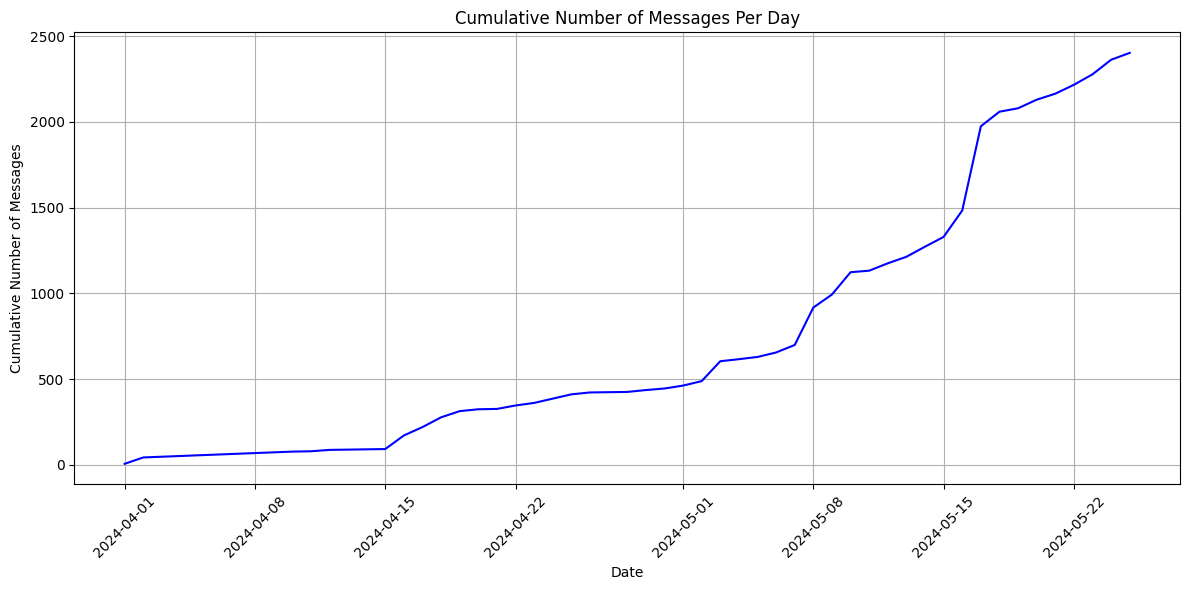

In [12]:
df_chats = dataframes['chats']
df_messages = dataframes['messages']
df_sessions = dataframes['sessions']

df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_messages_filtered = pd.merge(df_messages, df_chats[['id', 'course_id', 'session_id']], left_on='chat_id', right_on='id', how='left')

df_messages_filtered = pd.merge(df_messages_filtered, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_messages_filtered = df_messages_filtered[df_messages_filtered['is_test_user'] == False]

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_messages_filtered = df_messages_filtered[~df_messages_filtered['course_id'].isin([1, 6])]

messages_per_day = df_messages_filtered.groupby(df_messages_filtered['created_at'].dt.date).size()
cumulative_messages_per_day = messages_per_day.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_messages_per_day.index, cumulative_messages_per_day.values, marker='', linestyle='-', color='b')
plt.title('Cumulative Number of Messages Per Day')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Messages')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

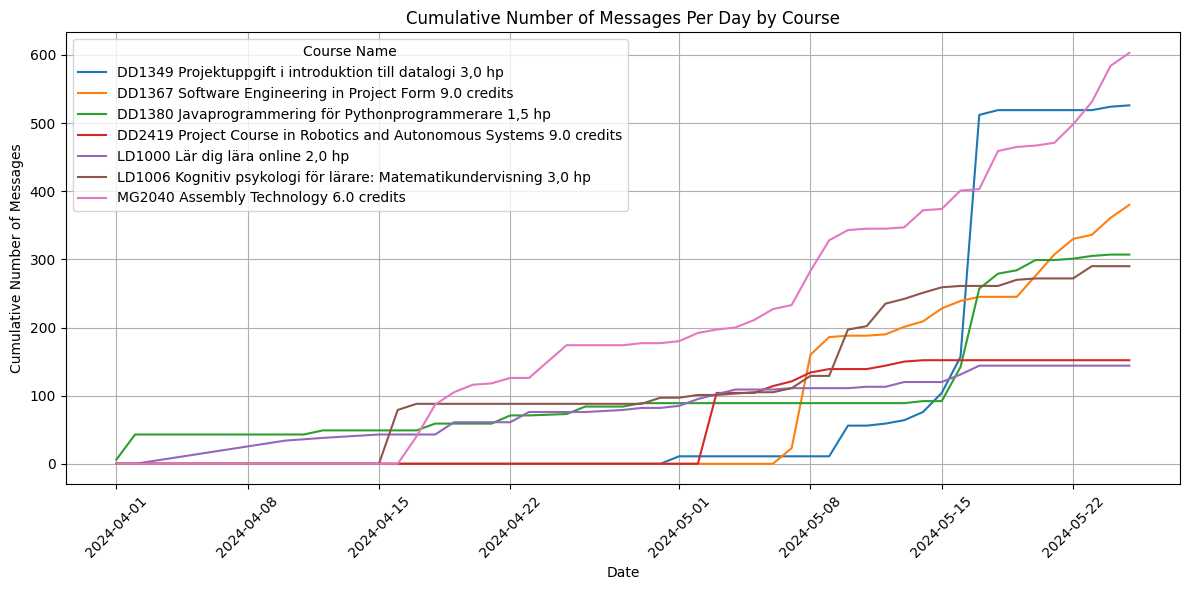

In [13]:
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_messages_filtered = pd.merge(df_messages, df_chats[['id', 'course_id', 'session_id']], left_on='chat_id', right_on='id', how='left')

df_messages_filtered = pd.merge(df_messages_filtered, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_messages_filtered = df_messages_filtered[df_messages_filtered['is_test_user'] == False]

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_messages_filtered = df_messages_filtered[~df_messages_filtered['course_id'].isin([1, 6])]

df_messages_with_names = pd.merge(df_messages_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

messages_per_day_per_course = df_messages_with_names.groupby(['name', df_messages_with_names['created_at'].dt.date]).size().unstack(fill_value=0)

cumulative_messages_per_course = messages_per_day_per_course.cumsum(axis=1).T

plt.figure(figsize=(12, 6))
for course_name in cumulative_messages_per_course.columns:
    plt.plot(cumulative_messages_per_course.index, cumulative_messages_per_course[course_name], marker='', linestyle='-', label=course_name)

plt.title('Cumulative Number of Messages Per Day by Course')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Messages')
plt.legend(title='Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Unique users

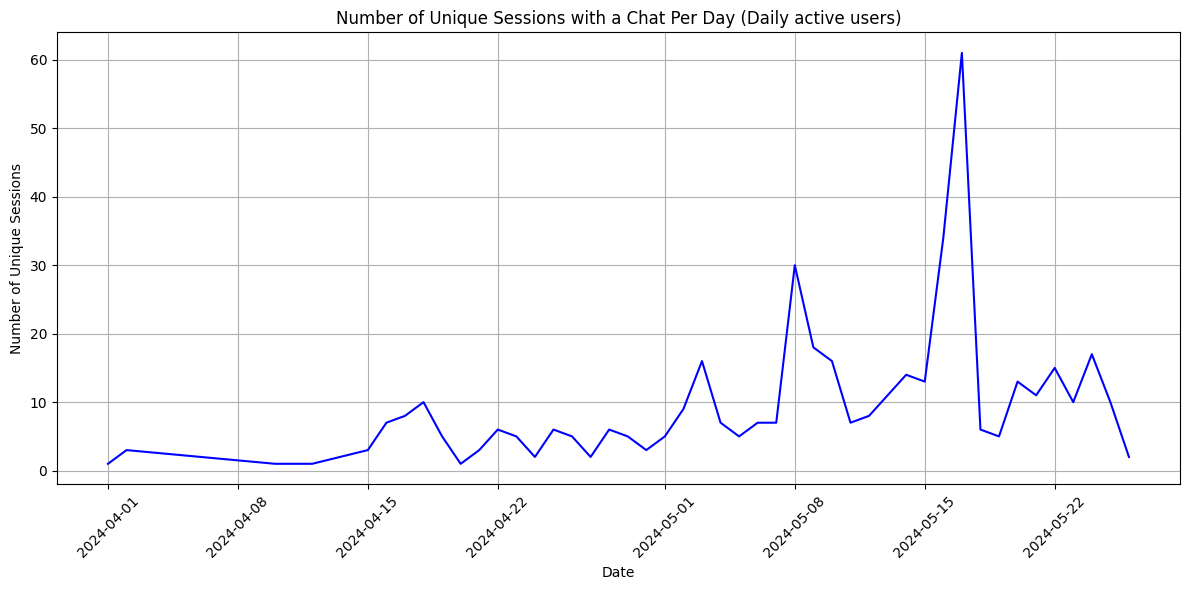

In [14]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])
df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_chats_filtered = df_chats[~df_chats['course_id'].isin([1, 6])]

unique_sessions_per_day = df_chats_filtered.groupby(df_chats_filtered['created_at'].dt.date)['session_id'].nunique()

plt.figure(figsize=(12, 6))
plt.plot(unique_sessions_per_day.index, unique_sessions_per_day.values, marker='', linestyle='-', color='b')
plt.title('Number of Unique Sessions with a Chat Per Day (Daily active users)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Sessions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

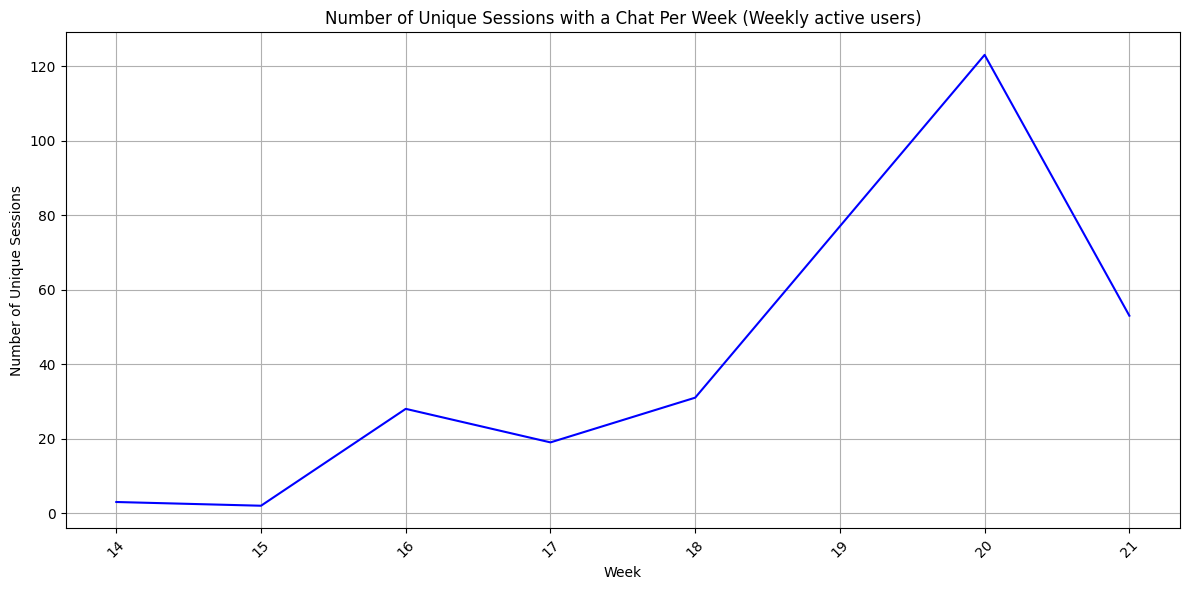

In [15]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])
df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_chats_filtered = df_chats[~df_chats['course_id'].isin([1, 6])]

unique_sessions_per_week = df_chats_filtered.groupby(df_chats_filtered['created_at'].dt.isocalendar().week)['session_id'].nunique()

plt.figure(figsize=(12, 6))
plt.plot(unique_sessions_per_week.index.astype(str), unique_sessions_per_week.values, marker='', linestyle='-', color='b')
plt.title('Number of Unique Sessions with a Chat Per Week (Weekly active users)')
plt.xlabel('Week')
plt.ylabel('Number of Unique Sessions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

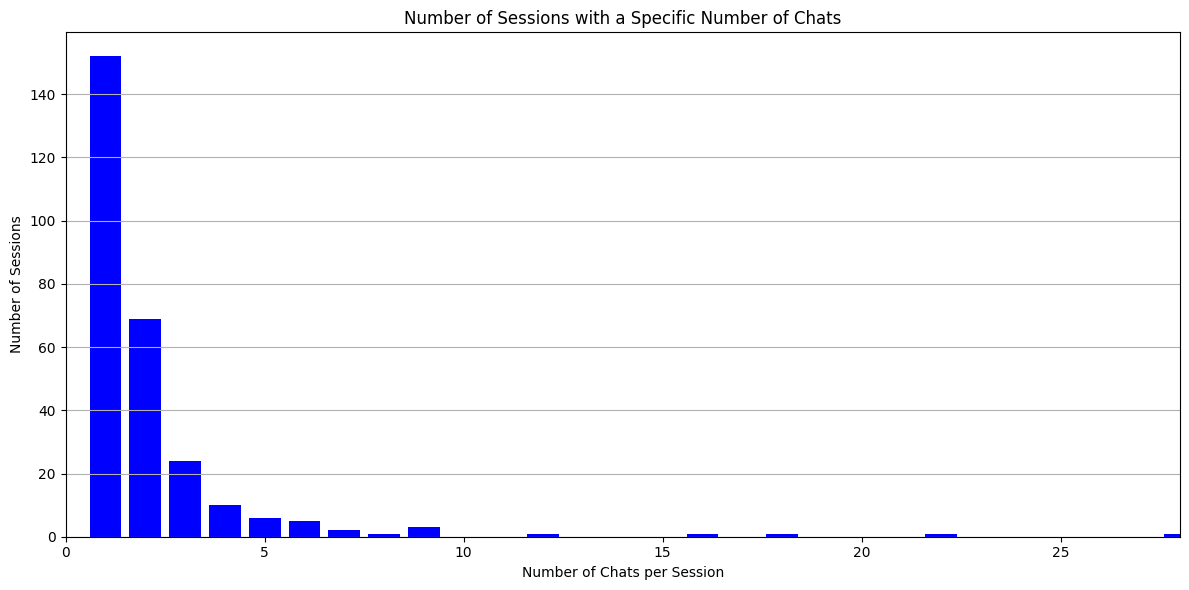

In [16]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_chats_filtered = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_chats_filtered = df_chats_filtered[df_chats_filtered['is_test_user'] == False]

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_chats_filtered = df_chats_filtered[~df_chats_filtered['course_id'].isin([1, 6])]

chats_per_session = df_chats_filtered['session_id'].value_counts()

sessions_per_chat_count = chats_per_session.value_counts().sort_index()

limit = sessions_per_chat_count.index[-2]

plt.figure(figsize=(12, 6))
plt.bar(sessions_per_chat_count.index, sessions_per_chat_count.values, color='b')
plt.title('Number of Sessions with a Specific Number of Chats')
plt.xlabel('Number of Chats per Session')
plt.ylabel('Number of Sessions')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.xlim(0, limit)
plt.tight_layout()
plt.show()

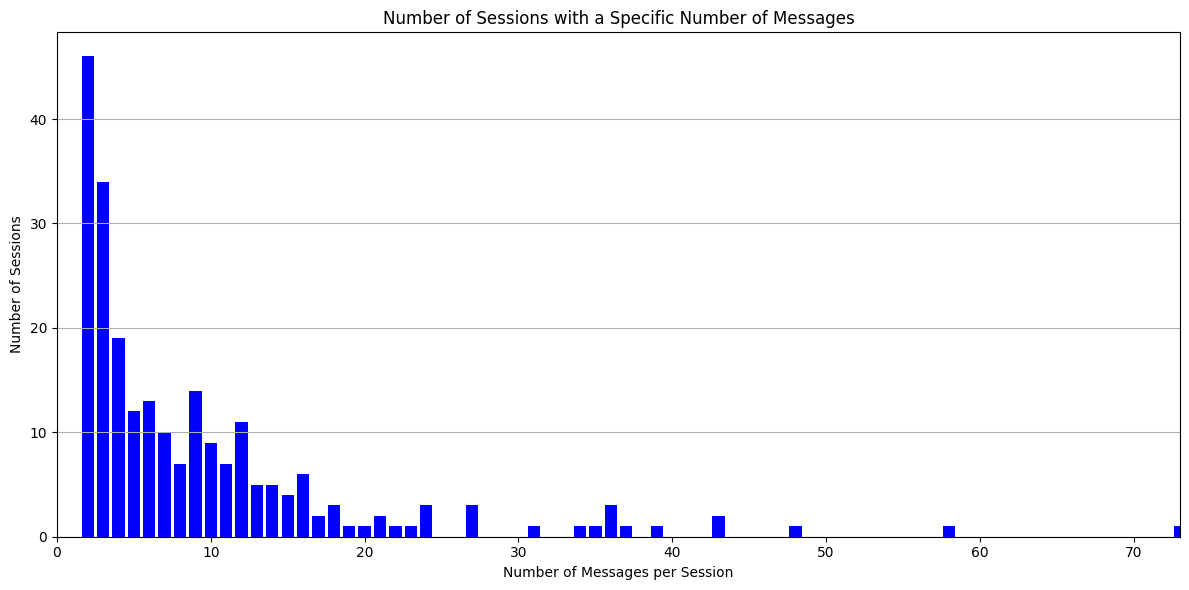

In [17]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_messages = dataframes['messages']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])

df_messages_filtered = pd.merge(df_messages, df_chats[['id', 'course_id', 'session_id']], left_on='chat_id', right_on='id', how='left')

df_messages_filtered = pd.merge(df_messages_filtered, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_messages_filtered = df_messages_filtered[df_messages_filtered['is_test_user'] == False]

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_messages_filtered = df_messages_filtered[~df_messages_filtered['course_id'].isin([1, 6])]

messages_per_session = df_messages_filtered['session_id'].value_counts()

sessions_per_message_count = messages_per_session.value_counts().sort_index()

limit = sessions_per_message_count.index[-2]

plt.figure(figsize=(12, 6))
plt.bar(sessions_per_message_count.index, sessions_per_message_count.values, color='b')
plt.title('Number of Sessions with a Specific Number of Messages')
plt.xlabel('Number of Messages per Session')
plt.ylabel('Number of Sessions')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.xlim(0, limit)
plt.tight_layout()
plt.show()